# Assignment 7: Dimensionality Reduction

## Follow These Steps Before Submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking **'Runtime' > 'Restart session and run all'**.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.

# Dataset

In this assignment, you will work on a text dataset. The Yelp reviews dataset consists of reviews from Yelp. It is extracted from the Yelp Dataset Challenge 2015 data. For more information, please refer to http://www.yelp.com/dataset_challenge. The Yelp reviews polarity dataset is a subset of Yelp reviews dataset and is constructed by considering stars 1 and 2 negative, and 3 and 4 positive.

In [ ]:
# imports
import os
import numpy as np
import pandas as pd
import polars as pl
from scipy.sparse import csr_matrix
import sklearn.feature_extraction.text as sktext
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
import re
from sklearn.manifold import TSNE

import umap

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
!gdown https://drive.google.com/uc?id=1A0-Q7SbdoA3r7aawraRSwMgKujBYlFLv

Downloading...
From: https://drive.google.com/uc?id=1A0-Q7SbdoA3r7aawraRSwMgKujBYlFLv
To: /content/yelp.csv
100% 1.09M/1.09M [00:00<00:00, 70.6MB/s]


# Part 1: Data Preprocessing

## Question 1.1: Load data

Read the **`yelp.csv`** file as a **`polars.DataFrame`** and show the first 5 rows of the dataframe and its descriptive statistics.

In [ ]:
# YOUR CODE HERE
data = pl.read_csv('yelp.csv')
data.head()

Sentiment,Review
i64,str
0,"""Maintenance here is ridiculous…"
1,"""I really enjoy smaller more in…"
1,"""Looking at their menu, I was a…"
1,"""Best sandwiches in Las Vegas! …"
0,"""Was upset because they didnt h…"


In [ ]:
data.describe()

statistic,Sentiment,Review
str,f64,str
"""count""",1500.0,"""1500"""
"""null_count""",0.0,"""0"""
"""mean""",0.494,null
"""std""",0.500131,null
"""min""",0.0,"""$24 for a burger and beer. \n…"
"""25%""",0.0,null
"""50%""",0.0,null
"""75%""",1.0,null
"""max""",1.0,"""wow, where do I begin? It too…"


## Question 1.2: Convert categorical variable

Since we are not predicting the categorical variable in this assignment, let's convert **`Sentiment`** to string:
- Replace **1** with **`positive`**.
- Replace **0** with **`negative`**.

Display the first 5 rows of the resulting dataframe.


In [ ]:
# YOUR CODE HERE
# Replace 1 with positive and 0 with negative in polar dataframe format
data = data.with_columns(pl.col('Sentiment').map_elements(lambda x: 'positive' if x == 1 else 'negative'))
data.head()

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

Sentiment,Review
str,str
"""negative""","""Maintenance here is ridiculous…"
"""positive""","""I really enjoy smaller more in…"
"""positive""","""Looking at their menu, I was a…"
"""positive""","""Best sandwiches in Las Vegas! …"
"""negative""","""Was upset because they didnt h…"


In [ ]:
# Number of class of Sentiment
data['Sentiment'].value_counts()

Sentiment,count
str,u32
"""negative""",759
"""positive""",741


## Question 1.3: Transform text

Apply **`Term Frequency - Inverse Document Frequency`** transformation using [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html):
- Eliminate accents and other characters
- Eliminate stopwords
- Eliminate words that appear in less than 5% and words that appear in more than 95% of texts
- Apply sublinear tf scaling

Extract and save the word list. Report the number of words that are kept.

In [ ]:
# Clean the texts
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
def cleanhtml(text):
    cleantext = re.sub(CLEANR, '', text)
    return cleantext

# Apply the cleaning function to the texts
data = data.with_columns(pl.col('Review').map_elements(cleanhtml, return_dtype=pl.String))

In [ ]:
# YOUR CODE HERE
TfIDFTransformer = sktext.TfidfVectorizer(strip_accents='unicode', # Eliminate accents and special characters
                      stop_words='english', # Eliminates stop words.
                      min_df = 0.05, # Eliminate words that do not appear in more than 5% of texts
                      max_df = 0.95, # Eliminate words that appear in more than 95% of texts
                      sublinear_tf=True # Use sublinear weights (softplus)
                      )

In [ ]:
TfIDF_IMDB = TfIDFTransformer.fit_transform(data['Review'])
TfIDF_IMDB

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 22476 stored elements and shape (1500, 157)>

In [ ]:
print(f'Number of words kept: {TfIDF_IMDB.shape[1]}')

Number of words kept: 157


## Question 1.4: Explore words

Based on TF-IDF scores, show the 10 most often repeated words and the 10 least often repeated words.

Hint: You might need to use [`np.argsort`](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html). Pay attention to sorting order.

In [ ]:
# YOUR CODE HERE
# Show the 10 most often repeated words and the 10 least often repeated words.
print(TfIDF_IMDB[0,:])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 21 stored elements and shape (1, 157)>
  Coords	Values
  (0, 69)	0.13026666692420805
  (0, 151)	0.4905886188713136
  (0, 138)	0.2023174641755253
  (0, 24)	0.19236113222627513
  (0, 58)	0.2247033205063053
  (0, 136)	0.13944111452649008
  (0, 92)	0.18199548136409796
  (0, 101)	0.19873316460558754
  (0, 50)	0.2297165455808706
  (0, 153)	0.17212231285457782
  (0, 152)	0.19236113222627513
  (0, 86)	0.23307380212035392
  (0, 53)	0.16843931353339547
  (0, 150)	0.21175164406342079
  (0, 99)	0.23447043565766895
  (0, 154)	0.23307380212035392
  (0, 144)	0.17237597035560187
  (0, 26)	0.19829275549007094
  (0, 35)	0.15756197533106872
  (0, 89)	0.16474230178377228
  (0, 109)	0.2112675707194609


In [ ]:
word_list = TfIDFTransformer.get_feature_names_out()

word_tfidf_sums = np.array(TfIDF_IMDB.sum(axis=0)).flatten()

# Get indices of the top 10 most frequent words (highest TF-IDF sums)
top_10_indices = np.argsort(word_tfidf_sums)[-10:][::-1]
top_10_words = [(word_list[i], word_tfidf_sums[i]) for i in top_10_indices]

# Get indices of the 10 least frequent words (lowest TF-IDF sums)
bottom_10_indices = np.argsort(word_tfidf_sums)[:10]
bottom_10_words = [(word_list[i], word_tfidf_sums[i]) for i in bottom_10_indices]

In [ ]:
# Print the 10 most used words
print("10 Most Used Words:")
for word, tfidf_sum in top_10_words:
    print(f"{word}: {tfidf_sum}")

10 Most Used Words:
food: 113.17798669065253
place: 105.82993647858306
good: 102.83724576664162
great: 100.72364265498449
service: 85.10012196079663
like: 83.64240950483007
just: 81.57090620377625
time: 75.57373422808044
really: 67.74816232193139
don: 60.40044118675273


In [ ]:
# Print the 10 least used words
print("10 Least Used Words:")
for word, tfidf_sum in bottom_10_words:
    print(f"{word}: {tfidf_sum}")

10 Least Used Words:
having: 17.80916786617899
tell: 18.56291412231156
half: 18.623919975870606
decided: 18.708994298506042
town: 18.842851733906713
30: 18.928404001658173
finally: 18.981879098080007
kind: 19.07512832845327
review: 19.729003876679386
reviews: 19.79551186567566


# Part 2: Dimensionality Reduction

## Question 2.1: PCA

(1) Apply **normal PCA**. Set the number of components to 100. Report the percentage variance explained by the 100 PCs.

(2) Show the words that have positive weight in the **third PC** (index 2).

In [ ]:
# (1) YOUR CODE HERE: Apply normal PCA and set the number of components to 100. Report the percentage variance explained by the 100 PCs.
nPCA = PCA(n_components=100)
nPCA.fit(np.asarray(TfIDF_IMDB.todense()))

total_variance = np.sum(nPCA.explained_variance_ratio_) * 100
print('The total explained variance of the first 100 components is', round(nPCA.explained_variance_ratio_.sum()*100,5), "\b%")

The total explained variance of the first 100 components is 80.02212 %


In [ ]:
# (2) YOUR CODE HERE: Show the words that have positive weight in the **third PC** (index 2).
# Second component words that are positive
word_list[nPCA.components_[2,:] > 0]

array(['10', '20', '30', 'ask', 'asked', 'away', 'bad', 'business',
       'called', 'came', 'check', 'come', 'customer', 'decided', 'did',
       'didn', 'drinks', 'finally', 'food', 'friends', 'gave', 'got',
       'great', 'half', 'happy', 'hour', 'later', 'left', 'let',
       'location', 'long', 'manager', 'minutes', 'money', 'ok', 'open',
       'order', 'ordered', 'pay', 'price', 'recommend', 'restaurant',
       'review', 'said', 'server', 'service', 'staff', 'star', 'table',
       'tell', 'time', 'times', 'told', 'took', 'wait', 'wanted', 'wasn',
       'went', 'work'], dtype=object)

## Question 2.2: LSA

(1) Apply **LSA** using [`TruncatedSVD`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html). Set:
- number of components to 100
- number of iterations to 10
- random state to 2025.

Report the percentage variance explained by the 100 PCs.

(2) Show the five words that relate the most with the **fifth PC** (index 4). What would you name this principal component?

In [ ]:
# (1) YOUR CODE HERE
svd = TruncatedSVD(n_components = 100, # How many concepts to extract
          n_iter = 10, # How many iterations to run
          random_state = 2025 # Random state. As SVD is rotation-invariant, we need to set this
          )
svd.fit(TfIDF_IMDB)
print("Total explained variance:", round(svd.explained_variance_ratio_.sum()*100,5), "\b%")

Total explained variance: 80.44088 %


In [ ]:
# (2) YOUR CODE HERE
# Show the five words that relate the most with the fifth PC
print("Top five words that relate with the 5th PC:")
fifth_pc = svd.components_[4]
top_5_indices_svd = np.argsort(fifth_pc)[-5:][::-1]
top_5_words_svd = [(word_list[i], fifth_pc[i]) for i in top_5_indices_svd]
top_5_words_svd

Top five words that relate with the 5th PC:


[('good', 0.5365584281812555),
 ('service', 0.20806835487704323),
 ('nice', 0.1709665582253515),
 ('hotel', 0.17095620459644512),
 ('room', 0.1558956725535808)]

**Written answer:**

This principal component can be names as ***Hotel Service & Experience***, as it captures hotel-related reviews, which probably includes service quality, room conditions, and overall experience.

## Question 2.3: PCA vs LSA

Compare PCA and LSA. Comment on your findings.

**Written answer:**

- LSA Explained Slightly More Variance
  - LSA captured 80.44% of the variance, whereas PCA captured 80.02%.
  - LSA is slightly more effective at capturing the underlying structure of the text data.
- Reason:
  - PCA assumes normal distribution and is not designed specifically for sparse text data
  - It treats each feature, i.e., word, as independent, without considering semantic relationships.
  - LSA (using SVD) to capture latent structures in text data. It groups words with similar meanings together, making it more effective for text analysis.

## Question 2.4: t-SNE

Apply **t-SNE**. Set:
- number of components to 2
- random first inintialization
- try a perplexity of 2 and 10.
- tightness of natural clusters to 30
- auto learning rate
- maximum number of iterations to 1000
- maximum number of iterations without progress before we abort to 100
- use cosine metric
- gradient threshold to 0.0000001
- random state to 2025

Create a plot, showing 2D projection of our data using t-SNE for both perplexities, in separate plots. Remember to add labels and title.

Written answer: Compare the two projections. Which projection would you think separates the classes better? Why?

In [ ]:
# YOUR CODE HERE - Perplexity 2
tSNEmapper_2 = TSNE(n_components=2,        # How many dimensions to use. Never more than 2 or 3
           init='random',         # First initialization. Sparse matrices need 'random'.  Otherwise use 'pca'
           perplexity=2,         # Read below
           early_exaggeration=30.0,    # How tight are the initial clusters.
           learning_rate='auto',     # Related to above. Leave to auto
           max_iter=1000,         # Very important to let iterate enough
           n_iter_without_progress=100,  # Set early stopping
           metric='cosine',        # Metric to use to calculate distances.
           min_grad_norm=0.0000001,    # Minimum gradient to continue iterating
           verbose=1,           # Verbosity
           random_state=2025,        # Random seed
           n_jobs=2,           # Parallel processes
           )
TSNE_embedding_2 = tSNEmapper_2.fit_transform(TfIDF_IMDB)

[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.001s...
[t-SNE] Computed neighbors for 1500 samples in 0.238s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 291.321594
[t-SNE] KL divergence after 1000 iterations: 1.549195


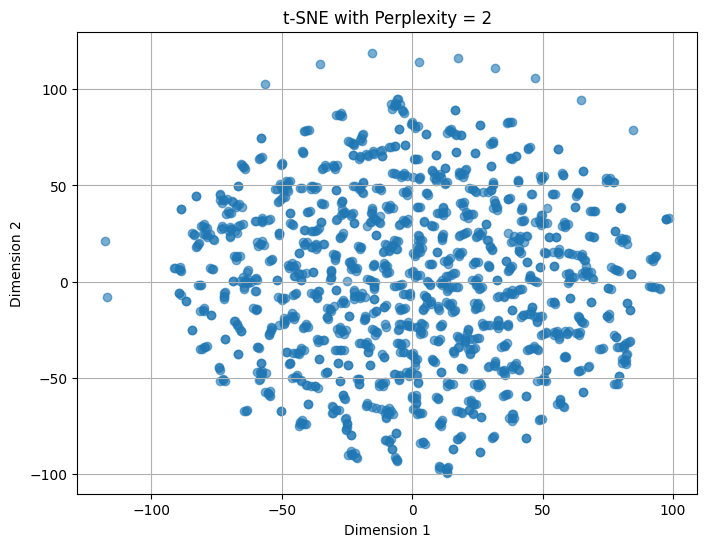

In [ ]:
# Plot - Perplexity 2
plt.figure(figsize=(8, 6))
plt.scatter(TSNE_embedding_2[:, 0], TSNE_embedding_2[:, 1], alpha=0.6)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("t-SNE with Perplexity = 2")
plt.grid(True)
plt.show()

In [ ]:
# YOUR CODE HERE - Perplexity 10
tSNEmapper_10 = TSNE(n_components=2,        # How many dimensions to use. Never more than 2 or 3
           init='random',         # First initialization. Sparse matrices need 'random'.  Otherwise use 'pca'
           perplexity=10,         # Read below
           early_exaggeration=30.0,    # How tight are the initial clusters.
           learning_rate='auto',     # Related to above. Leave to auto
           max_iter=1000,         # Very important to let iterate enough
           n_iter_without_progress=100,  # Set early stopping
           metric='cosine',        # Metric to use to calculate distances.
           min_grad_norm=0.0000001,    # Minimum gradient to continue iterating
           verbose=1,           # Verbosity
           random_state=2025,        # Random seed
           n_jobs=2,           # Parallel processes
           )
TSNE_embedding_10 = tSNEmapper_10.fit_transform(TfIDF_IMDB)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.001s...
[t-SNE] Computed neighbors for 1500 samples in 0.177s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 0.178814
[t-SNE] KL divergence after 250 iterations with early exaggeration: 246.630936
[t-SNE] KL divergence after 1000 iterations: 2.558254


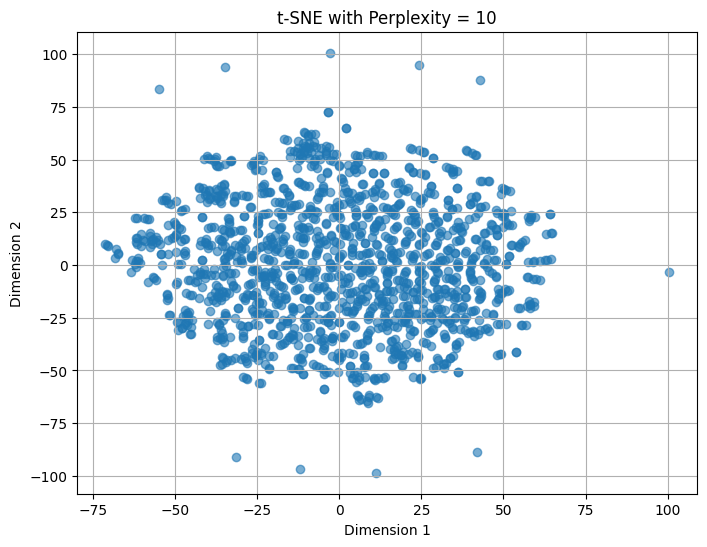

In [ ]:
# Plot - Perplexity 10
plt.figure(figsize=(8, 6))
plt.scatter(TSNE_embedding_10[:, 0], TSNE_embedding_10[:, 1], alpha=0.6)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("t-SNE with Perplexity = 10")
plt.grid(True)
plt.show()

**Written Answer:**
- Perplexity = 2
    - The points appear more dispersed and scattered.
    - Overall structure is less compact.
    - Some points are isolated and widely spaced apart.
- Perplexity = 10
  - The points are more tightly packed.
  - There is more global structure, meaning that the distances between clusters are more meaningful.
  - There are still some outliers, but the clusters are more distinct and well-separated.

- Perplexity = 10 separates the classes better because:
  - More compact and structured groupings,
  - Higher perplexity considers more nearest neighbors, which helps capture both local and global patterns.
  - The reduced noise suggests that data points within the same class may be more concentrated.

## Question 2.5: UMAP

(1) Apply **UMAP**. Set:
- number of components to 2
- use 10 nearest neighbors
- use cosine metric
- number of training epochs to 1000
- effective minimum distance between embedded points to 0.1
- effective scale of embedded points to 1
- avoids excessive memory use
- do not use a random seed to allow parallel processing.

(2) Create a plot, showing 2D projection of our data using UMAP. Remember to add labels and title.

In [ ]:
# (1) YOUR CODE HERE
reducer = umap.UMAP(n_neighbors=10,   # Number of neareast neighbours to use.
           n_components=2,   # Number of components. UMAP is robust to larger values
           metric='cosine',   # Metric to use.
           n_epochs=1000,    # Iterations. Set to convergence. None implies either 200 or 500.
           min_dist=0.1,    # Minimum distance embedded points. Smaller makes clumps, larger, sparseness.
           spread=1.0,     # Scale to combine with min_dist
           low_memory=False,  # Run slower, but with less memory.
           n_jobs=-1,      # Cores to use
           verbose=True     # Verbosity
           )

UMAP_embedding = reducer.fit_transform(TfIDF_IMDB)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP(angular_rp_forest=True, low_memory=False, metric='cosine', n_epochs=1000, n_neighbors=10, verbose=True)
Sat Mar 15 19:06:22 2025 Construct fuzzy simplicial set
Sat Mar 15 19:06:22 2025 Finding Nearest Neighbors
Sat Mar 15 19:06:25 2025 Finished Nearest Neighbor Search
Sat Mar 15 19:06:29 2025 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Sat Mar 15 19:06:35 2025 Finished embedding


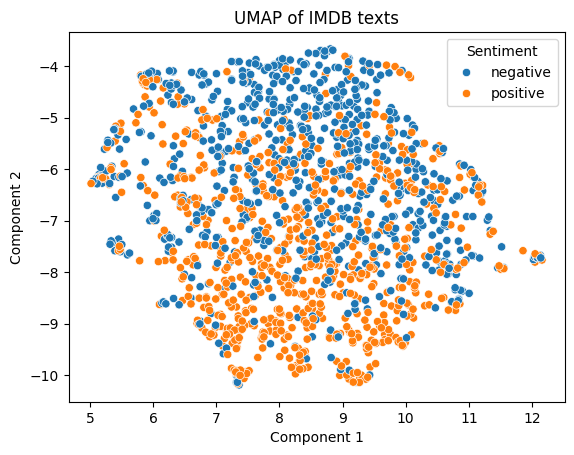

In [ ]:
# (2) YOUR CODE HERE: Plot
sns.scatterplot(x=UMAP_embedding[:, 0], y=UMAP_embedding[:, 1], hue=data['Sentiment'])
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("UMAP of IMDB texts")
plt.show()

## Question 2.6: t-SNE vs UMAP

Compare t-SNE (perplexity 10) and UMAP. Comment on your findings.

**Written answer:**
- t-SNE (Perplexity = 10)
  - Clusters are not as well-separated
  - The distribution is dense.
  - Few clear decision boundaries between classes
  - Preserves local structure

- UMAP
  - Better separation of classes
  - Two classes are more distinctly organized compared to t-SNE.
  - Preserves both local and global structure, which makes it more effective for text-based embeddings.

-  UMAP is better than t-SNE because:
  - Better class separation: The positive and negative sentiments form distinct regions in the UMAP plot.
  - Preserves both local & global structures
  - Faster and scalable: UMAP is computationally more efficient than t-SNE
  - More interpretable